In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
import geopandas
import skimage

from scipy import stats
from skimage.color import label2rgb
from skimage.measure import regionprops, regionprops_table, perimeter
from skimage.segmentation import mark_boundaries, slic
from skimage.util import map_array
from sklearn.ensemble import RandomForestClassifier
from rich.progress import track

In [2]:
def stretch_histogram(band, min_out=0, max_out=255):
    min_in, max_in = np.percentile(band, (2, 98))  # Considerando 2% - 98% para evitar outliers
    stretched = (band - min_in) * ((max_out - min_out) / (max_in - min_in)) + min_out
    stretched = np.clip(stretched, min_out, max_out)
    return stretched / 255

# Define custom features
def std(regionmask, intensity_img):
    vals = intensity_img[regionmask]
    std = np.std(vals)
    return std

def rectangularity(regionmask):
    return regionmask.sum()/regionmask.size

def compactness(regionmask):
    return 4*np.pi*regionmask.sum()/(perimeter(regionmask)**2 + 1e-6)  # small value added to avoid division by zero

def entropy_ndvi(regionmask, intensity_img):
    vals = intensity_img[regionmask]
    arr = stats.relfreq(vals, 100, defaultreallimits=(-1,1))[0]
    return stats.entropy(arr)

# Calculate set of various features for each segment
def calc_all_feats(seg_arr, img_arr):
    spectral_feats = pd.DataFrame(
        regionprops_table(
            label_image = seg_arr,
            intensity_image = img_arr,
            properties = ["label", "intensity_mean"],
            extra_properties=(std,)
        )
    )
    shape_feats = pd.DataFrame(
        regionprops_table(
            label_image = seg_arr,
            properties = ["solidity"],
            extra_properties=(rectangularity, compactness)
        )
    )

    textural_feats = pd.DataFrame(
        regionprops_table(
            label_image = seg_arr,
            intensity_image =img_arr[:, :, -1],  # Use only the NDVI band
            properties = [],
            extra_properties=(entropy_ndvi,)
        )
    )

    all_feats = pd.concat([spectral_feats, shape_feats, textural_feats], axis=1)

    return all_feats

In [3]:
img_path = './images/Crops_USA.tif' #image path


In [4]:
#load image
with rio.open(img_path) as src:
    img = src.read([1,2,3,4]).astype(float) 
    
    max_value = img.max()
    img /= max_value  # Image Normalize
    
    red, green, blue, nir = img

In [5]:
rgb = stretch_histogram(np.stack([red, green, blue], axis = -1))

ndvi = (nir - red) / (nir + red + 1e-6)

image = np.stack([red, green, blue, nir], axis = -1)

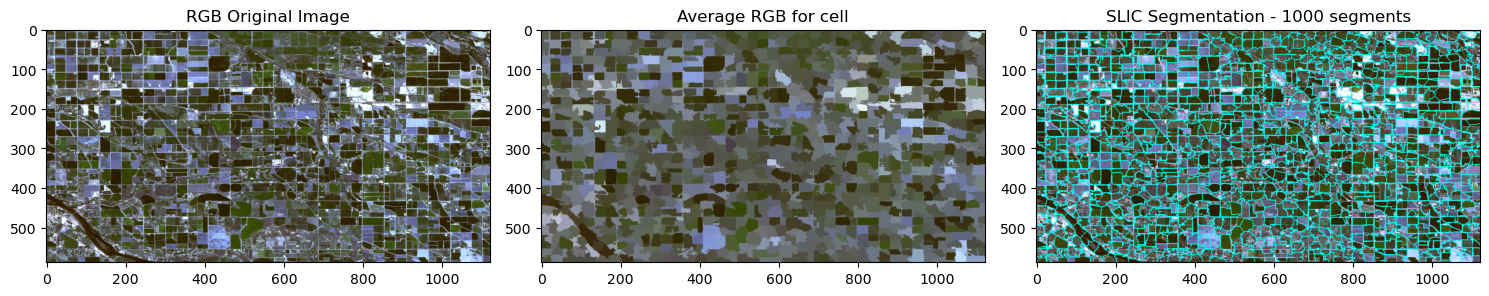

In [6]:
n_segments = 1000
val_compactness = 30

segments = slic(rgb, n_segments=n_segments, compactness=val_compactness, start_label=1)

fig, ax = plt.subplots(nrows = 1, ncols=3, figsize = (15,10))

ax[0].imshow(rgb)
ax[0].set_title('RGB Original Image')

ax[1].imshow(label2rgb(segments, rgb, kind='avg'))
ax[1].set_title('Average RGB for cell')

ax[2].imshow(mark_boundaries(rgb, segments, color = (0,1,1), mode = "thick"))
ax[2].set_title(f"SLIC Segmentation - {n_segments} segments")

plt.tight_layout()
plt.show()

In [7]:
#Feature Extraction
stack = np.stack([red, green, blue, nir, ndvi], axis = -1)


all_features_df = calc_all_feats(segments, stack)
all_features_df = all_features_df.rename(columns={'label':'idx'})

In [8]:
all_features_df

idx  intensity_mean-0  intensity_mean-1  intensity_mean-2  \
0      1          0.130650          0.134064          0.121156   
1      2          0.165275          0.175569          0.187905   
2      3          0.108572          0.107961          0.084888   
3      4          0.132224          0.136059          0.130036   
4      5          0.209046          0.216173          0.239127   
..   ...               ...               ...               ...   
873  874          0.107648          0.107756          0.081361   
874  875          0.105684          0.093373          0.067198   
875  876          0.118377          0.111236          0.096904   
876  877          0.120136          0.123611          0.097995   
877  878          0.115210          0.122484          0.098600   

     intensity_mean-3  intensity_mean-4     std-0     std-1     std-2  \
0            0.156670          0.077813  0.021089  0.026664  0.041837   
1            0.216997          0.133419  0.040153  0.046491  0.069236   
2            0.135177          0.108606  0.005143  0.006408  0.009695   
3            0.170822          0.122888  0.027270  0.033094  0.049972   
4            0.251931          0.099811  0.094035  0.095129  0.104073   
..                ...               ...       ...       ...       ...   
873          0.132975          0.095840  0.019354  0.025421  0.036665   
874          0.081746         -0.193687  0.013436  0.021545  0.027392   
875          0.125845          0.026335  0.011316  0.012413  0.023087   
876          0.145090          0.088879  0.019617  0.018930  0.033864   
877          0.160481          0.163506  0.006230  0.007477  0.012135   

        std-3     std-4  solidity  rectangularity  compactness  entropy_ndvi  
0    0.042021  0.070770  0.945364        0.877112     0.699052      2.245596  
1    0.052327  0.049745  0.393000        0.289609     0.116171      2.299171  
2    0.008863  0.020920  0.998519        0.998519     0.833113      1.369374  
3    0.041902  0.047066  0.676133        0.544662     0.272017      2.120666  
4    0.089299  0.078731  0.308140        0.220741     0.116956      2.596380  
..        ...       ...       ...             ...          ...           ...  
873  0.035701  0.056797  0.832000        0.656566     0.308701      2.323374  
874  0.044955  0.227948  0.895548        0.726389     0.541348      3.039785  
875  0.020067  0.046172  0.924731        0.754386     0.589199      2.207447  
876  0.029044  0.061890  0.889423        0.790598     0.488185      2.432114  
877  0.011622  0.023738  0.909722        0.652824     0.486687      1.547233  

[878 rows x 15 columns]

# Rule Based Classification

# Check the rule in the future.

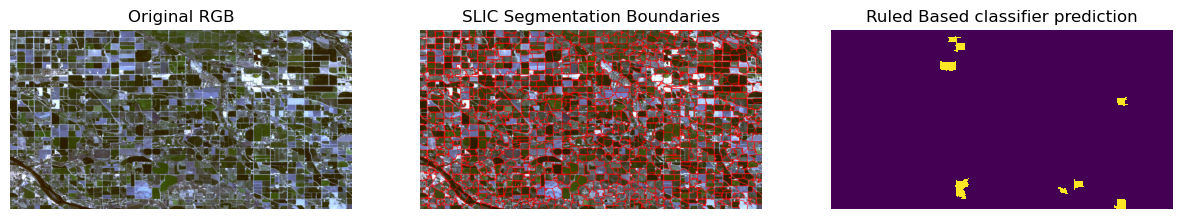

In [9]:
#Classification Rule
all_features_df['classification'] = (
    (all_features_df['intensity_mean-4'] > 0.2) &
    (all_features_df['rectangularity'] > 0.35) &
    (all_features_df['compactness'] > 0.3) & (all_features_df['compactness'] < 0.75) &
    (all_features_df['entropy_ndvi'] > 1.75) 
).astype(int)
#With this rule we seek to classify segments that represent the river or water bodies.

mapped_rules = map_array(
    segments,
    np.array(all_features_df['idx']),
    np.array(all_features_df['classification'])
)

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,10))

# Display the original RGB image
ax[0].imshow(rgb)
ax[0].set_title("Original RGB")

# Display the RGB image with segmentation boundaries for 3000 segments
ax[1].imshow(mark_boundaries(rgb, segments, color=(1, 0, 0), mode="thick"))
ax[1].set_title(f"SLIC Segmentation Boundaries")

# Display the prediction result
# Define the colors:
# [-1] = undefined segments (grey), [0] = non-trees (dark blue), [1] = trees (green)
#background_c, others_c, trees_c = '#7f8282', '#00008b', '#00FF00'
#binary_cmap = mcolors.ListedColormap([background_c, others_c, trees_c])
ax[2].imshow(mapped_rules, interpolation="nearest")
ax[2].set_title("Ruled Based classifier prediction")

# Remove axis for all subplots
for axis in ax:
    axis.set_axis_off()

# Display the combined figure
plt.show()

# Machine Learning Classification

In [12]:
urban_idx = [
    374, 312, 207, 684,834, 522, 232, 294, 782, 229
]

crops_idx = [
    326, 132, 739, 155, 484, 189, 408, 386, 665, 203
]

# Initialize the 'class' column in all_feats_df to -1 (for unlabeled segments)
all_features_df['classification'] = -1

# Update the 'class' column for tree segments (label 1)
all_features_df.loc[all_features_df['idx'].isin(urban_idx), 'classification'] = 1

# Update the 'class' column for non-tree segments (label 0)
all_features_df.loc[all_features_df['idx'].isin(crops_idx), 'classification'] = 0

# Display the DataFrame
display(all_features_df)

idx  intensity_mean-0  intensity_mean-1  intensity_mean-2  \
0      1          0.130650          0.134064          0.121156   
1      2          0.165275          0.175569          0.187905   
2      3          0.108572          0.107961          0.084888   
3      4          0.132224          0.136059          0.130036   
4      5          0.209046          0.216173          0.239127   
..   ...               ...               ...               ...   
873  874          0.107648          0.107756          0.081361   
874  875          0.105684          0.093373          0.067198   
875  876          0.118377          0.111236          0.096904   
876  877          0.120136          0.123611          0.097995   
877  878          0.115210          0.122484          0.098600   

     intensity_mean-3  intensity_mean-4     std-0     std-1     std-2  \
0            0.156670          0.077813  0.021089  0.026664  0.041837   
1            0.216997          0.133419  0.040153  0.046491  0.069236   
2            0.135177          0.108606  0.005143  0.006408  0.009695   
3            0.170822          0.122888  0.027270  0.033094  0.049972   
4            0.251931          0.099811  0.094035  0.095129  0.104073   
..                ...               ...       ...       ...       ...   
873          0.132975          0.095840  0.019354  0.025421  0.036665   
874          0.081746         -0.193687  0.013436  0.021545  0.027392   
875          0.125845          0.026335  0.011316  0.012413  0.023087   
876          0.145090          0.088879  0.019617  0.018930  0.033864   
877          0.160481          0.163506  0.006230  0.007477  0.012135   

        std-3     std-4  solidity  rectangularity  compactness  entropy_ndvi  \
0    0.042021  0.070770  0.945364        0.877112     0.699052      2.245596   
1    0.052327  0.049745  0.393000        0.289609     0.116171      2.299171   
2    0.008863  0.020920  0.998519        0.998519     0.833113      1.369374   
3    0.041902  0.047066  0.676133        0.544662     0.272017      2.120666   
4    0.089299  0.078731  0.308140        0.220741     0.116956      2.596380   
..        ...       ...       ...             ...          ...           ...   
873  0.035701  0.056797  0.832000        0.656566     0.308701      2.323374   
874  0.044955  0.227948  0.895548        0.726389     0.541348      3.039785   
875  0.020067  0.046172  0.924731        0.754386     0.589199      2.207447   
876  0.029044  0.061890  0.889423        0.790598     0.488185      2.432114   
877  0.011622  0.023738  0.909722        0.652824     0.486687      1.547233   

     classification  
0                -1  
1                -1  
2                -1  
3                -1  
4                -1  
..              ...  
873              -1  
874              -1  
875              -1  
876              -1  
877              -1  

[878 rows x 16 columns]

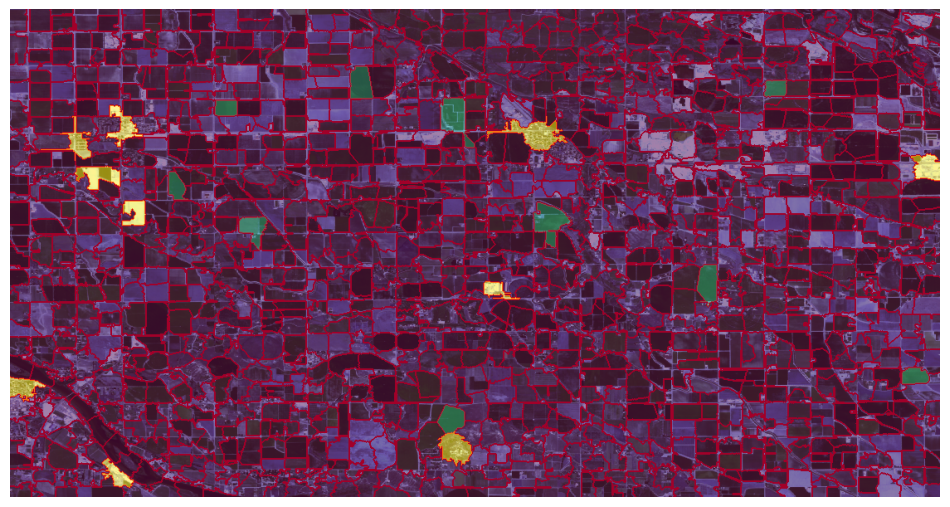

In [13]:
mapped_samples = map_array(
    segments, 
    np.array(all_features_df['idx']),
    np.array(all_features_df['classification'])
)

# Display the original image with segment boundaries
plt.figure(figsize=(12, 8))
plt.imshow(mark_boundaries(rgb, segments, (1, 0, 0), mode="outer"))

# Overlay the labeled segments with the defined colors
plt.imshow(mapped_samples, alpha=0.5)

# Turn off the axis for a cleaner look
plt.axis("off")

# Show the plot
plt.show()

## Train Random Forest Classifier

In [14]:
labeled_segments = all_features_df[all_features_df['classification'] != -1]

X_train = labeled_segments.drop(columns = ['idx','classification'])
y_train = labeled_segments['classification']

clf = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
clf.fit(X_train,y_train)

print('OOB Score:', clf.oob_score_)

OOB Score: 0.9


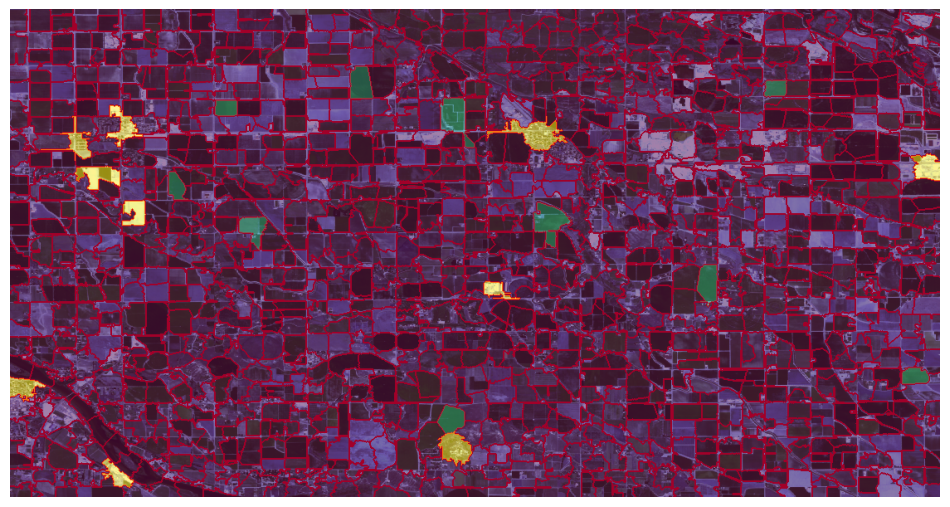

In [15]:
# Display the original image with segment boundaries
plt.figure(figsize=(12, 8))
plt.imshow(mark_boundaries(rgb, segments, (1, 0, 0), mode="outer"))

# Overlay the labeled segments with the defined colors
plt.imshow(mapped_samples, alpha=0.5)

# Turn off the axis for a cleaner look
plt.axis("off")

# Show the plot
plt.show()

In [16]:
# Filter out the unlabeled segments
unlabeled_segments_df = all_features_df[all_features_df['classification'] == -1]

# Separate features (X) for the unlabeled segments
X_test = unlabeled_segments_df.drop(columns=['idx', 'classification'])

# Predict the class labels for the unlabeled segments
predictions = clf.predict(X_test)

# Update the original dataframe with the predictions
all_features_df.loc[all_features_df['classification'] == -1, 'classification'] = predictions

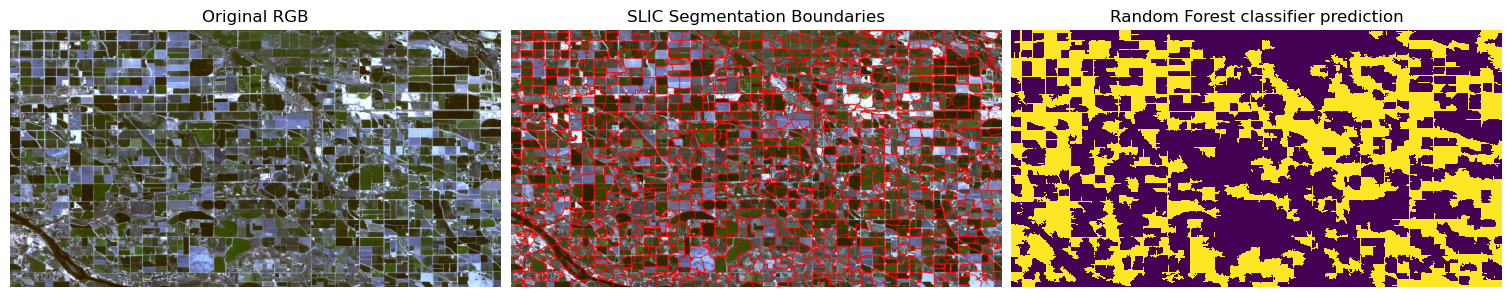

In [17]:
mapped_rf_classification= map_array(
    segments,
    np.array(all_features_df["idx"]),
    np.array(all_features_df["classification"]))

# Create the figure with 3 subplots
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)

# Display the original RGB image
axs[0].imshow(rgb)
axs[0].set_title("Original RGB")

# Display the RGB image with segmentation boundaries for 3000 segments
axs[1].imshow(mark_boundaries(rgb, segments, color=(1, 0, 0), mode="thick"))
axs[1].set_title(f"SLIC Segmentation Boundaries")

# Display the prediction result
axs[2].imshow(mapped_rf_classification, interpolation="nearest")
axs[2].set_title("Random Forest classifier prediction")

# Remove axis for all subplots
for ax in axs:
    ax.set_axis_off()

# Display the combined figure
plt.show()
